# Parámetros globales del *Notebook*

In [1]:
# Para definir los path
import os

# Define si estamos ejecutando el Notebook en nuestro 
# ordenador ("local") o en Google Colab ("remote")
RUNNING_ENV = "local"

# Path que vamos a usar como base para el resto de paths
BASE_PATH = "./" if RUNNING_ENV == "local" else "/content/drive/MyDrive/Colab Notebooks/"

# Directorio en el que guardamos los scripts de python que usamos 
# como libreria propia
LIB_PATH = os.path.join(BASE_PATH, "lib")

# Directorio en el que guardamos los datos de entrenamiento y test
DATA_PATH = os.path.join(BASE_PATH, "data")

# Numero de procesos que queremos usar
NUM_WORKERS = 2

# Batch size que queremos usar para los dataloaders que usamos
DATALOADER_BACH_SIZE = 32

# Tamaño del conjunto de triples aleatorios
# Tiene que ser un multiplo de DATALOADER_BACH_SIZE para que
# la red tome correctamente los batches que espera
# TODO -- esto nunca lo he tenido que hacer asi que seguramente estemos
# haciendo algo mal
RANDOM_TRIPLETS_DATA_SIZE = DATALOADER_BACH_SIZE * 10

# Numero de epocas por las que queremos entrenar
TRAINING_EPOCHS = 10

# Margen para la funcion de perdida
MARGIN = 1.0

# Autorización si estamos usando Google Drive

In [2]:
if RUNNING_ENV == "remote":
    from google.colab import drive
    drive.mount('/content/drive')

# Importando los módulos que vamos a usar

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
import torchvision.datasets as datasets

# Para poder usar ResNet18 preentrenado
import torchvision.models as models 
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Cargamos en el Notebook todos los ficheros .py que definen nuestra propia libreria
# Usamos esta libreria para escribir el codigo base necesario para llevar a cabo ciertas
# tareas del notebook (como el bucle de entrenamiento) que no tienen interes mostrar
# en este notebook
!cp -r "$LIB_PATH"/* .

# Ahora que hemos cargado estos ficheros en el Notebook, importamos lo necesario
# de nuestra propia libreria
import core
import time
import copy
import board
import filesystem
from train_loggers import ClassificationLogger, SilentLogger, TripletLogger, TrainLogger
from models.resnet import *
from visualizations import *
from custom_loss import triplet_loss_batch_hard
from tqdm.notebook import tqdm


# Funciones comunes que vamos a usar en el notebook

In [4]:
# TODO -- de momento no tenemos nada asi que esto ahora mismo lo podriamos borrar

# Carga del conjunto de datos

In [5]:
# Transformaciones que queremos aplicar al cargar los datos
# Ahora solo pasamos las imagenes a tensores, pero podriamos hacer aqui normalizaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    # TODO -- aqui podemos añadir la normaliazcion de datos
])

# Cargamos el dataset usando torchvision, que ya tiene el conjunto
# preparado para descargar
train_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = True,
    download = True,
    transform = transform,
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = False,
    download = True,
    transform = transform,
)

# Data loaders para acceder a los datos
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)
test_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size = DATALOADER_BACH_SIZE,
  shuffle = True,
  num_workers = NUM_WORKERS,
  pin_memory = True,
)

# Definiendo las clases con las que vamos a trabajar

In [6]:
# Clases con las que vamos a trabajar
# Esta lista especifica la relacion numero -> nombre de la forma
# classes[numero] = nombre
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)

# Análisis Exploratorio de datos

Mostramos algunas imágenes con sus clases para asegurar que hemos cargado correctamente las imágenes del conjunto de datos:

La clase obtenida es: Pullover


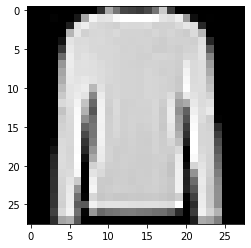

La clase obtenida es: Dress


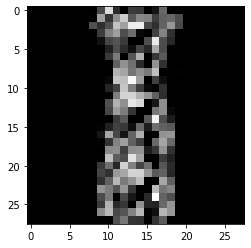

La clase obtenida es: Trouser


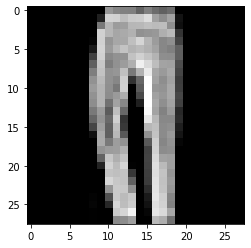

La clase obtenida es: Ankle boot


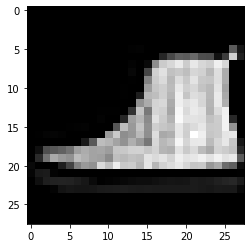

La clase obtenida es: Shirt


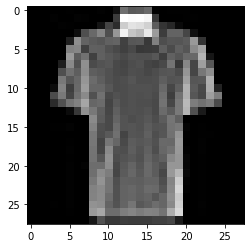

In [7]:
imgs_to_show = 5

for _ in range(imgs_to_show):

    # Cargamos un batch de imagenes
    images, images_classes = next(iter(train_loader))

    # Nos quedamos con la primera imagen del batch
    img, img_class = images[0], images_classes[0]

    # Mostramos alguna informacion de la imagen
    print(f"La clase obtenida es: {classes[img_class]}")

    # Re-escalamos y mostramos la imagen
    img = img.reshape((28, 28))
    show_img(img, color_format_range = (-1.0, 1.0))

Mostramos ahora unas cuantas imágenes de forma simultánea:

Mostramos ahora los tamaños del dataset:

In [8]:
print(f"Tenemos {len(train_dataset)} imágenes de entrenamiento")
print(f"Tenemos {len(test_dataset)} imágenes de test")

Tenemos 60000 imágenes de entrenamiento
Tenemos 10000 imágenes de test


# Definiendo el modelo base

- A continuación, definimos el modelo que vamos a usasr como base para nuestra red siamesa
- Usaremos el modelo pre-entrenado ResNet18, pre-entrenado en ImageNet

In [9]:
class ResNet18(torch.nn.Module):
    def __init__(self):
        
        super(ResNet18, self).__init__()
        
        # Tomamos el modelo pre-entrenado ResNet18
        self.pretrained = models.resnet18(pretrained=True)
        
        # Cambiamos la primera convolucion para que en vez
        # de tres canales acepte un canal para las imagenes
        # de entrada
        self.pretrained.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size=7, stride=2, padding=3, bias=False)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # Tenemos como entrada tensores (1, 32, 28, 28) y 
        # queremos tensores (32, 1, 28, 28) para poder trabajar
        # con la red pre-entrenada
        x = torch.reshape(x, (32, 1, 28, 28))

        # Usamos directamente la red pre-entrenada para hacer el forward
        return self.pretrained.forward(x)

# Generación de triples

- Para entrenar la red siamesa, necesitamos dar triples con los que computar el *triplet loss*
- Por ello, es necesaria una fase previa de *triplets mining*
- En todos los casos, crearemos *Datasets* de *Pytorch* para representar la creación de los triples
- Hacemos esto basándonos el la [documentación oficial de Pytorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

## Generación de triples aleatorios

- Es la forma más sencilla y directa para generar triples
- Usaremos esta generación como baseline para más tarde realizar comparaciones

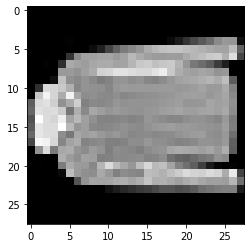

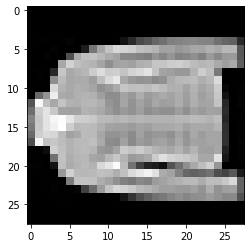

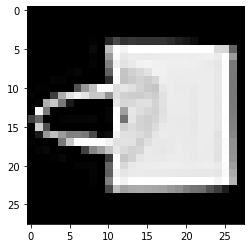

In [10]:
# TODO -- hay que implementar esto
from torch.utils.data import RandomSampler


class RandomTriplets(Dataset):
    """
    Dataset en el que los elementos son triples obtenidos de forma aleatoria
    """

    def __init__(self, base_data: Dataset, custom_len: int, transform = None):
        self.base_data = base_data
        self.custom_len = custom_len
        self.transform = transform
        self.random_sampler = RandomSampler(self.base_data, replacement=True, num_samples=1, generator=None)
        
        # Por motivos de eficiencia, pre-computamos una lista de listas, de forma
        # que tengamos disponibles las listas con las posiciones de cada clase por
        # separado.
        self.posiciones_clases = self.__precompute_list_of_classes()

    def __len__(self):
        """
        Devolvemos el tamaño del dataset
        Como estamos generando triples aleatorios, devolvemos el tamaño definido
        por parametro
        """
        return self.custom_len

    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Funcion que es llamada cuando se hace dataset[idx]
        En vez de devolver una imagen (que es lo comun en esta clase dataset), 
        devolvemos un triple (anchor, positive, negative) aleatorio
        """

        # Hacemos esto por temas de eficiencia
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Tomamos una imagen aleatoria que sera el ancla
        anchor, anchor_class = self.base_data[next(iter(self.random_sampler))]

        # Tomamos una imagen de la misma clase, que sera la positiva, de forma aleatoria
        random_index = np.random.choice(self.posiciones_clases[anchor_class])
        positive, positive_class = self.base_data[random_index]

        # Tomamos una imagen de otra clase, que sera la negativa
        # Empiezo tomando una clase que no sea la del anchor
        posible_classes = list(range(10))
        posible_classes.remove(anchor_class)
        negative_class = np.random.choice(posible_classes)

        # Ahora tomamos un indice aleatorio de esta clase negativa
        random_index = np.random.choice(self.posiciones_clases[negative_class])
        negative, negative_class = self.base_data[random_index]
        
        # Generamos ahora el triple
        triplet = [anchor, positive, negative]

        # Aplicamos la transformacion dada al dataset al ejemplo que devolvemos
        if self.transform:
            triplet = [self.transform(np.array(img)) for img in triplet]

        return triplet

    def __precompute_list_of_classes(self) -> List[List[int]]:
        """
        Calcula la lista con las listas de posiciones de cada clase por separado
        """
        # Inicializamos la lista de listas
        posiciones_clases = [[] for _ in range(10)]

        # Recorremos el dataset y colocamos los indices donde corresponde
        for idx, element in enumerate(self.base_data):
            _, img_class = element
            posiciones_clases[img_class].append(idx)

        return posiciones_clases

    
class CustomReshape(object):
    """Pasamos la imagen de (28, 1, 28) a (28, 28)"""

    def __call__(self, image):
        image = image.reshape(28, 28)
        return image
    
# Necesitamos hacer reshape de las imagenes para que
# sean (28, 28) y no (28, 1, 28)
transform = transforms.Compose([
    transforms.ToTensor(),
    
    # Hacemos reshape de las imagenes para
    # que sean tensores (28, 28)
    CustomReshape(),
])

random_triplets = RandomTriplets(
    base_data = train_dataset,
    custom_len = RANDOM_TRIPLETS_DATA_SIZE,
    transform = transform,
)

# Data loaders para acceder a los datos
train_loader = torch.utils.data.DataLoader(
    random_triplets,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

# TODO -- esto habria que borrarlo, esta aqui para hacer pruebas
#Visualizamos un triple
custom_triplet = random_triplets[2]
for i in custom_triplet :
    show_img(i, color_format_range = (-1.0, 1.0))

# Entrenamiento del modelo

In [11]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        
        # Comprobaciones de seguridad
        # TODO -- recuperar esta comprobacion
        #if anchor.shape[0] != 1 or positive.shape[0] != 1 or negative.shape[0] != 1:
            
            # Construimos el mensaje de error para saber que ha fallado
            #err_msg = "Los tensores dados deben tener un unico elemento \n"
            #err_msg += f"anchor.shape = {anchor.shape}\n"
            #err_msg += f"positive.shape = {positive.shape}\n"
            #err_msg += f"negative.shape = {negative.shape}\n"
            
            # Levantamos la excepcion con el mensaje
            #raise ValueError(err_msg)
        
        distance_positive = self.__euclidean_distance(anchor, positive)
        distance_negative = self.__euclidean_distance(anchor, negative)

        # Usamos Relu para que el error sea cero cuando la resta de las distancias
        # este por debajo del margen. Si esta por encima del margen, devolvemos la
        # identidad de dicho error. Es decir, aplicamos Relu a la formula que 
        # tenemos debajo
        loss = torch.relu(distance_positive - distance_negative + self.margin)

        return loss

    def __euclidean_distance(self, first: torch.Tensor, second: torch.Tensor) -> float:
        return ((first - second) * (first - second)).sum()

class TripletLossCustom(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLossCustom, self).__init__()
        self.margin = margin
        self.base_loss = TripletLoss(self.margin)
    
    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        losses = torch.tensor(
            [self.base_loss(current[0], current[1], current[2]) for current in batch], 
            requires_grad=True
        )
        return losses.mean()

In [12]:
def train_model(
    net: nn.Module,
    path: str,
    parameters: dict,
    train_loader: DataLoader,
    validation_loader: DataLoader = None,
    name: str = "Model",
    logger: TrainLogger = None,
    snapshot_iterations: int = None
) -> None:
    """
    Trains and saves a neural net

    Parameters:
    ===========
    net: Module representing a neural net to train
    path: dir where models are going to be saved
    parameters: dict having the following data:
                - "lr": learning rate
                - "momentum": momentum of the optimizer
                - "criterion": loss function
                - "epochs": epochs to train
    train_loader: pytorch DataLoader wrapping training set
    validation_loader: pytorch DataLoader wrapping validation set
    name: name of the model, in order to save it
    train_logger: to log data about trainning process
                  Default logger is silent logger
    snapshot_iterations: at how many iterations we want to take an snapshot of the model
                         If its None, no snapshots are taken
    """

    # Loss and optimizer
    lr = parameters["lr"]
    momentum = parameters["momentum"]
    criterion = parameters["criterion"]
    
    # TODO -- usar ADAM en vez de SGD
    optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)

    # Select proper device and move the net to that device
    device = core.get_device()
    net.to(device)

    # Check if no logger is given
    if logger is None:
        print("==> No logger given, using Silent Logger")
        logger = SilentLogger()

    # Printing where we're training
    print(f"==> Training on device {device}")
    print("")

    # Training the network
    epochs = parameters["epochs"]
    for epoch in range(epochs):

        for i, data in enumerate(train_loader):
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = [net(item[None, ...].to(device)) for item in data]
            loss = criterion(outputs)

            # Backward + Optimize
            loss.backward()
            optimizer.step()

            # Statistics -- important, we have to use the iteration given by current epoch and current
            # iteration counter in inner loop. Otherwise logs are going to be non-uniform over iterations
            curr_it = epoch * len(train_loader.dataset) + i * train_loader.batch_size
            if logger.should_log(curr_it):
                logger.log_process(train_loader, validation_loader, epoch, i)

            # Snapshots -- same as Statistics, we reuse current iteration calc
            # TODO -- create a SnapshotTaker class as we have for logs -- snapshot_taker.should_log(i)
            if snapshot_iterations is not None and curr_it % snapshot_iterations == 0:
                # We take the snapshot
                snapshot_name = "snapshot_" + name + "==" + core.get_datetime_str()
                snapshot_folder = os.path.join(path, "snapshots")
                filesystem.save_model(net, folder_path = snapshot_folder, file_name = snapshot_name)

    print("Finished training")

    # Save the model -- use name + date stamp to save the model
    date = core.get_datetime_str()
    name = name + "==" + date
    filesystem.save_model(net = net, folder_path = path, file_name = name)



In [13]:
net = ResNet18()

# TODO -- fijar bien los parametros
parameters = dict()
parameters["epochs"] = TRAINING_EPOCHS
parameters["lr"] = 0.001
parameters["momentum"] = 0.9
parameters["criterion"] = TripletLossCustom(MARGIN)

# Definimos el logger que queremos para el entrenamiento
logger = TripletLogger(
    net = net,
    iterations = 4 * DATALOADER_BACH_SIZE,
    loss_func = parameters["criterion"],
    training_perc = 1.0,
    validation_perc = 1.0
)

print(net)

ResNet18(
  (pretrained): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
train_model(
    net = net,
    path = os.path.join(BASE_PATH, "tmp"),
    parameters = parameters,
    train_loader = train_loader,
    
    # TODO -- no tenemos conjunto de validacion
    validation_loader = None,
    name = "SiameseNetwork",
    logger = logger,
    snapshot_iterations = None
)

==> Training on device cuda:0

Evaluando en la epoca 0 e iteracion 0
Evaluando en la epoca 0 e iteracion 4
Evaluando en la epoca 0 e iteracion 8
Evaluando en la epoca 1 e iteracion 2
Evaluando en la epoca 1 e iteracion 6
Evaluando en la epoca 2 e iteracion 0
Evaluando en la epoca 2 e iteracion 4
Evaluando en la epoca 2 e iteracion 8
Evaluando en la epoca 3 e iteracion 2
Evaluando en la epoca 3 e iteracion 6
Evaluando en la epoca 4 e iteracion 0
Evaluando en la epoca 4 e iteracion 4
Evaluando en la epoca 4 e iteracion 8
Evaluando en la epoca 5 e iteracion 2
Evaluando en la epoca 5 e iteracion 6
Evaluando en la epoca 6 e iteracion 0
Evaluando en la epoca 6 e iteracion 4
Evaluando en la epoca 6 e iteracion 8
Evaluando en la epoca 7 e iteracion 2
Evaluando en la epoca 7 e iteracion 6
Evaluando en la epoca 8 e iteracion 0
Evaluando en la epoca 8 e iteracion 4
Evaluando en la epoca 8 e iteracion 8
Evaluando en la epoca 9 e iteracion 2
Evaluando en la epoca 9 e iteracion 6
Finished training


# Evaluación del modelo

- Mostramos algunas métricas fundamentales sobre el conjunto de

In [15]:
# TODO -- hay que implementar algunas metricas

# Adaptación del modelo para usarlo como clasificador

- Nuestro modelo genera un *embedding*
- Adaptamos el modelo para que, a partir de dicho embedding, podamos usarlo como un clasificador

In [16]:
# TODO -- adaptar el modelo

## Evaluación del clasificador obtenido

- Ahora que hemos adaptado el modelo para usarlo como clasificador, podemos consultar ciertas métricas de clasificación

In [17]:
# TODO -- implementar las métricas de clasificación